# Beyond Language: Aligning AI across Modalities - Audio Generation with Human Feedback

This notebook demonstrates how human feedback methods, such as RLHF, can be applied to generative models beyond text. Here, we focus on audio generation and preference modeling, showing how to align AI outputs with human values in new domains.

## 1. Setup: Libraries for Generative Audio and Feature Extraction

We use Hugging Face's `transformers` for text-to-audio generation (MusicGen), and `librosa`/`soundfile` for audio processing. These tools enable us to generate audio clips from text prompts and analyze their properties.

In [1]:
!pip install -r requirements.txt


## 2. Audio Generation and Feature Extraction

We generate audio clips from text prompts using MusicGen. To make preferences interpretable, we extract simple audio features: spectral centroid (brightness) and zero-crossing rate (energy). These features serve as proxies for "calm" vs "energetic" music.

In [2]:
import torch, numpy as np, librosa, soundfile as sf
from transformers import pipeline
from IPython.display import Audio, display

# Load once
generator = pipeline("text-to-audio", model="facebook/musicgen-small")

def generate_audio(prompt: str, seed: int | None = None):
    # MusicGen pipeline doesn't take `seed`; seed the RNG directly.
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    out = generator(prompt)  # returns dict or list[dict]
    item = out[0] if isinstance(out, list) else out
    audio = item["audio"]
    sr = item.get("sampling_rate", 32000)
    return audio.astype(np.float32), sr

def extract_features(audio: np.ndarray, sr: int) -> np.ndarray:
    # Simple, transparent proxies for calm vs energetic
    centroid = float(librosa.feature.spectral_centroid(y=audio, sr=sr).mean())
    zcr      = float(librosa.feature.zero_crossing_rate(y=audio).mean())
    return np.array([centroid, zcr], dtype=np.float32)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


## 3. Preference Modeling: Bradley-Terry Model

To simulate RLHF, we use pairwise comparisons between audio clips. The Bradley-Terry model learns feature weights that best explain these preferences, allowing us to rank future generations according to learned human-like criteria.

In [3]:
import numpy as np
from scipy.optimize import minimize

# comparisons: list of (i, j, y) where y=1 if i preferred over j, else 0
def bt_negloglik(w: np.ndarray, X: np.ndarray, comparisons: list[tuple[int,int,int]]) -> float:
    scores = X @ w  # latent score per item
    loss = 0.0
    for i, j, y in comparisons:
        si, sj = scores[i], scores[j]
        diff = si - sj
        # P(i > j) = sigmoid(si - sj)
        p = 1 / (1 + np.exp(-diff))
        loss -= y * np.log(p + 1e-9) + (1 - y) * np.log(1 - p + 1e-9)
    return loss

def train_bt(X: np.ndarray, comparisons: list[tuple[int,int,int]]) -> np.ndarray:
    w0 = np.zeros(X.shape[1], dtype=np.float64)
    res = minimize(bt_negloglik, w0, args=(X, comparisons), method="BFGS")
    return res.x  # learned feature weights

def preference_score(features: np.ndarray, w: np.ndarray) -> float:
    return float(features @ w)


## 4. Safe Audio Playback

This utility ensures generated audio is played back correctly in the notebook, handling mono and stereo formats.

In [4]:
def safe_audio(audio: np.ndarray, sr: int):
    audio = np.array(audio).squeeze()  # remove singleton dims
    if audio.ndim == 1:      # mono
        return Audio(audio, rate=sr)
    elif audio.ndim == 2:    # (channels, samples) -> transpose
        if audio.shape[0] < audio.shape[1]:
            audio = audio.T
        return Audio(audio, rate=sr)
    else:
        raise ValueError(f"Unexpected audio shape {audio.shape}")

## 5. Candidate Generation, Feature Extraction, and Ranking

We generate multiple candidate audio clips for a prompt, extract their features, and simulate pairwise preferences. The learned preference model is then used to rank the candidates, demonstrating how RLHF can guide generative models in non-language domains.

In [8]:
import soundfile as sf
from IPython.display import Audio, display
from transformers import pipeline

# --- Create pipeline once (outside loops) ---
gen_pipe = pipeline("text-to-audio", model="facebook/musicgen-small")

# --- Candidate generation with feature extraction + scoring ---
def generate_candidates(prompt, n=3):
    outs = gen_pipe([prompt] * n, forward_params={"do_sample": True, "max_new_tokens": 256})
    clips = []
    for i, out in enumerate(outs):
        audio = out["audio"]
        sr = out["sampling_rate"]
        feats = extract_features(audio, sr)
        clips.append((audio, sr, feats, i))
    return clips

# Example pool
candidates = generate_candidates("a calm piano melody", n=3)

# Build feature matrix for BT training
X = np.array([c[2] for c in candidates])

# Synthetic pairwise prefs: prefer lower centroid
comparisons = []
for i in range(len(candidates)):
    for j in range(i+1, len(candidates)):
        yi = 1 if candidates[i][2][0] < candidates[j][2][0] else 0
        comparisons.append((i, j, yi))

# Train BT weights
w_bt = train_bt(X, comparisons)
print("Learned BT weights:", np.round(w_bt, 4))

# Rank candidates (use learned BT model consistently)
ranked = sorted(
    [(audio, sr, feats, preference_score(feats, w_bt), idx)
     for audio, sr, feats, idx in candidates],
    key=lambda x: -x[3]
)

# Show results + audio
for audio, sr, feats, score, idx in ranked:
    print(f"Candidate {idx} | feats={np.round(feats,2)} | BT score={score:.4f}")
    display(Audio(audio.flatten(), rate=sr))



Device set to use cuda:0


Learned BT weights: [-1.01 -0.  ]
Candidate 0 | feats=[4.9981e+02 2.0000e-02] | BT score=-504.8049


Candidate 1 | feats=[6.0798e+02 3.0000e-02] | BT score=-614.0643


Candidate 2 | feats=[7.429e+02 3.000e-02] | BT score=-750.3332


## 6. Visualizing Preference Scores

We visualize the preference scores assigned to each candidate, showing how the learned model can distinguish between different audio outputs. This step highlights the impact of human feedback (even if synthetic) on model alignment.

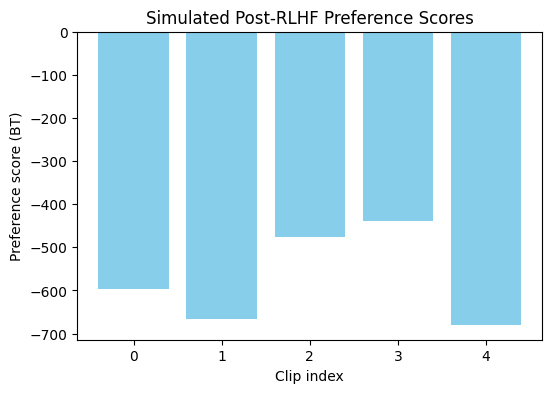

Clip 3 | feats=[4.3409e+02 2.0000e-02] | Score=-438.4342


Clip 2 | feats=[4.7136e+02 2.0000e-02] | Score=-476.0768


Clip 0 | feats=[5.9042e+02 3.0000e-02] | Score=-596.3194


Clip 1 | feats=[6.5886e+02 3.0000e-02] | Score=-665.4442


Clip 4 | feats=[6.7366e+02 3.0000e-02] | Score=-680.3995


In [10]:
import matplotlib.pyplot as plt

# --- Generate pre-RLHF candidates ---
pre_clips = generate_candidates("a calm piano melody", n=5)
pre_X = np.array([c[2] for c in pre_clips])
pre_scores = np.array([preference_score(feats, w_bt) for _, _, feats, idx in pre_clips])

# --- Rank post-RLHF candidates (simulated by preference model) ---
ranked_post = sorted(
    [(audio, sr, feats, score, idx)
     for (audio, sr, feats, idx), score in zip(pre_clips, pre_scores)],
    key=lambda x: -x[3]
)

# --- Display scores comparison ---
plt.figure(figsize=(6,4))
plt.bar(range(len(pre_scores)), pre_scores, color='skyblue')
plt.xlabel("Clip index")
plt.ylabel("Preference score (BT)")
plt.title("Simulated Post-RLHF Preference Scores")
plt.show()

# --- Play clips in ranked order ---
for audio, sr, feats, score, idx in ranked_post:
    print(f"Clip {idx} | feats={np.round(feats,2)} | Score={score:.4f}")
    display(Audio(audio.flatten(), rate=sr))



## Conclusion

This notebook illustrates the generalization of RLHF and human feedback methods to audio generation. By collecting preferences and training a simple model, we align generative outputs with desired properties—demonstrating that human feedback is a powerful tool for aligning AI across modalities.